FRP

In [1]:
# Turn point dataset into gridded dataset, where its horizontal resolution is 0.75º*0.75º

import pandas as pd
import numpy as np
import xarray as xr
import os

# === INPUT CSV FILE ===
csv_path = r"E:\IPMA\FRP\FRP_2000_2024.csv"

# === EXTRACT DIRECTORY AND CREATE OUTPUT FILENAME ===
base_dir = os.path.dirname(csv_path)
output_filename = "FRP_2000_2024.nc"
output_path = os.path.join(base_dir, output_filename)

# === GRID PARAMETERS ===
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34, 66
lon_min, lon_max = -12, 36

lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1]
lon_centers = lon_bins[:-1]

# === LOAD AND PREPARE DATA ===
print("Loading and filtering data...")
df = pd.read_csv(csv_path)
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Filter FRP values >= 100 MW
df = df[df['frp'] >= 100]

# Ensure date is datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Assign grid cell
print("Assigning points to grid cells...")
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_centers)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=lon_centers)
df.dropna(subset=['lat_bin', 'lon_bin'], inplace=True)

# Convert bins to float
df['lat_bin'] = df['lat_bin'].astype(float)
df['lon_bin'] = df['lon_bin'].astype(float)

# === AGGREGATE STATS ===
print("Aggregating FRP statistics...")
grouped = df.groupby(['acq_date', 'lat_bin', 'lon_bin'])

frp_stats = grouped['frp'].agg(
    FRP_sum='sum',
    FRP_mean='mean',
    FRP_median='median',
    FRP_max='max',
    FRP_min='min',
    FRP_std='std',
    count='count'
).reset_index()

# === CREATE FULL 3D ARRAYS ===
print("Creating 3D arrays...")

all_dates = pd.date_range(df['acq_date'].min(), df['acq_date'].max(), freq='D')
shape = (len(all_dates), len(lat_centers), len(lon_centers))

# Initialize arrays with NaNs
arrays = {
    'FRP_sum': np.full(shape, np.nan),
    'FRP_mean': np.full(shape, np.nan),
    'FRP_median': np.full(shape, np.nan),
    'FRP_max': np.full(shape, np.nan),
    'FRP_min': np.full(shape, np.nan),
    'FRP_std': np.full(shape, np.nan),
    'count': np.full(shape, np.nan),
}

lat_to_idx = {lat: i for i, lat in enumerate(lat_centers)}
lon_to_idx = {lon: i for i, lon in enumerate(lon_centers)}
date_to_idx = {date: i for i, date in enumerate(all_dates)}

# Fill arrays
for _, row in frp_stats.iterrows():
    d, lat, lon = row['acq_date'], row['lat_bin'], row['lon_bin']
    i, j, k = date_to_idx[d], lat_to_idx[lat], lon_to_idx[lon]
    for key in arrays:
        arrays[key][i, j, k] = row[key]

# === CREATE xarray.Dataset ===
print("Building xarray dataset...")
ds = xr.Dataset(
    {key: (["time", "latitude", "longitude"], arrays[key]) for key in arrays},
    coords={
        "time": all_dates,
        "latitude": lat_centers,
        "longitude": lon_centers,
    },
    attrs={
        "title": "Daily Gridded FRP Statistics (0.75° × 0.75°)",
        "source_file": os.path.basename(csv_path),
        "grid_resolution": "0.75 degrees",
        "description": "Includes daily FRP sum, mean, median, max, min, std, and detection count per grid cell"
    }
)

# === SAVE TO NETCDF ===
print(f"Saving to NetCDF: {output_path}")
ds.to_netcdf(output_path)
print("Done.")

Loading and filtering data...
Assigning points to grid cells...
Aggregating FRP statistics...
Creating 3D arrays...
Building xarray dataset...
Saving to NetCDF: E:\IPMA\FRP\FRP_2000_2024.nc
Done.


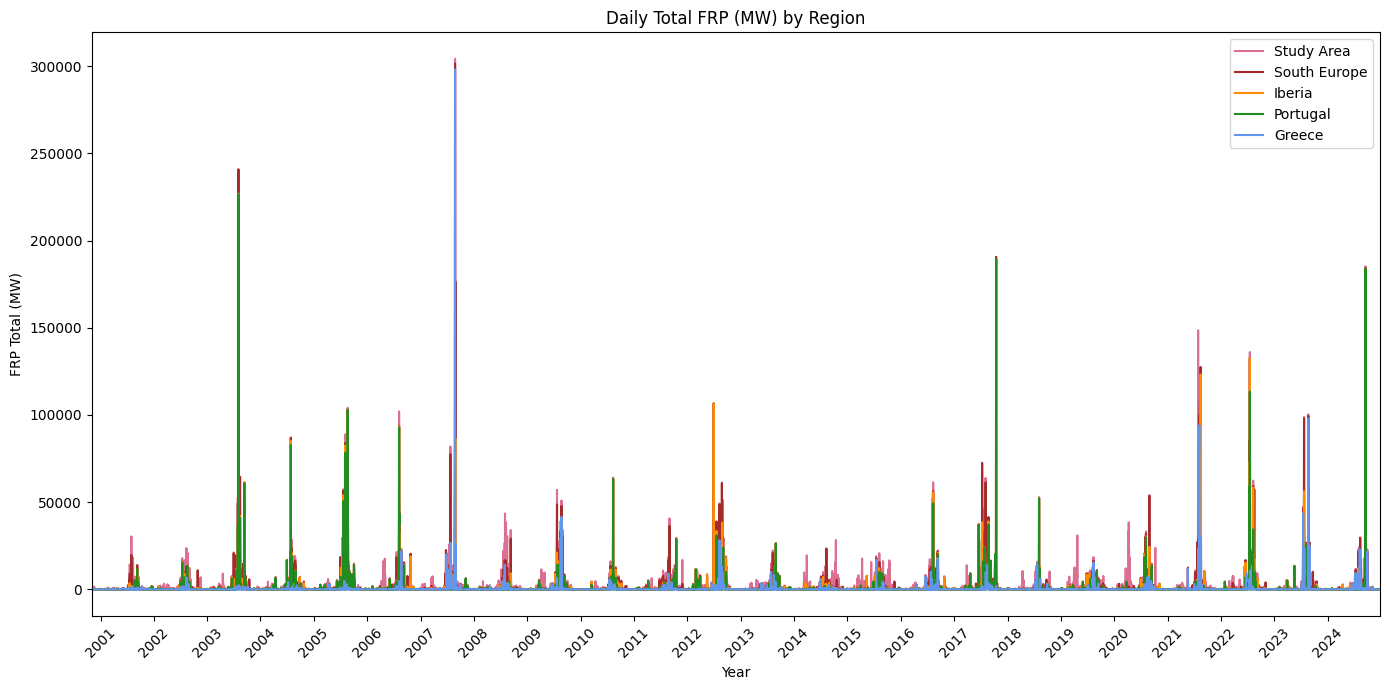

In [2]:
# Time series for daily sum of FRP over defined regions

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

# Load the NetCDF file
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# Define regions: (lat_min, lat_max, lon_min, lon_max, color)
regions = {
    "Study Area": (34, 66, -12, 36, "palevioletred"),
    "Iberia": (35, 45, -10, 5, "darkorange"),
    "Portugal": (36, 43, -10, -6, "forestgreen"),
    "Greece": (34, 42, 19, 29, "cornflowerblue"),
    "South Europe": (34, 45, -10, 29, "brown"),
}

# Access the daily sum FRP variable
frp_sum = ds["FRP_sum"]

# Dictionary to store time series for each region
region_series = {}

for name, (lat_min, lat_max, lon_min, lon_max, color) in regions.items():
    # Subset the region
    subset = frp_sum.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Calculate daily regional total (sum over lat/lon)
    daily_total = subset.sum(dim=["latitude", "longitude"], skipna=True)
    
    # Convert to pandas Series
    region_series[name] = pd.Series(daily_total.values, index=pd.to_datetime(daily_total["time"].values))

# Plotting
# Define the order you want to plot regions in
plot_order = ["Study Area", "South Europe", "Iberia", "Portugal", "Greece"]

plt.figure(figsize=(14, 7))

for name in plot_order:
    series = region_series[name]
    plt.plot(series.index, series, label=name, color=regions[name][4])

plt.title("Daily Total FRP (MW) by Region")
plt.xlabel("Year")
plt.ylabel("FRP Total (MW)")
plt.legend()

# Set x-axis limits based on all data
all_dates = pd.concat(region_series.values()).index
plt.xlim(all_dates.min(), all_dates.max())

# Format x-axis yearly
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


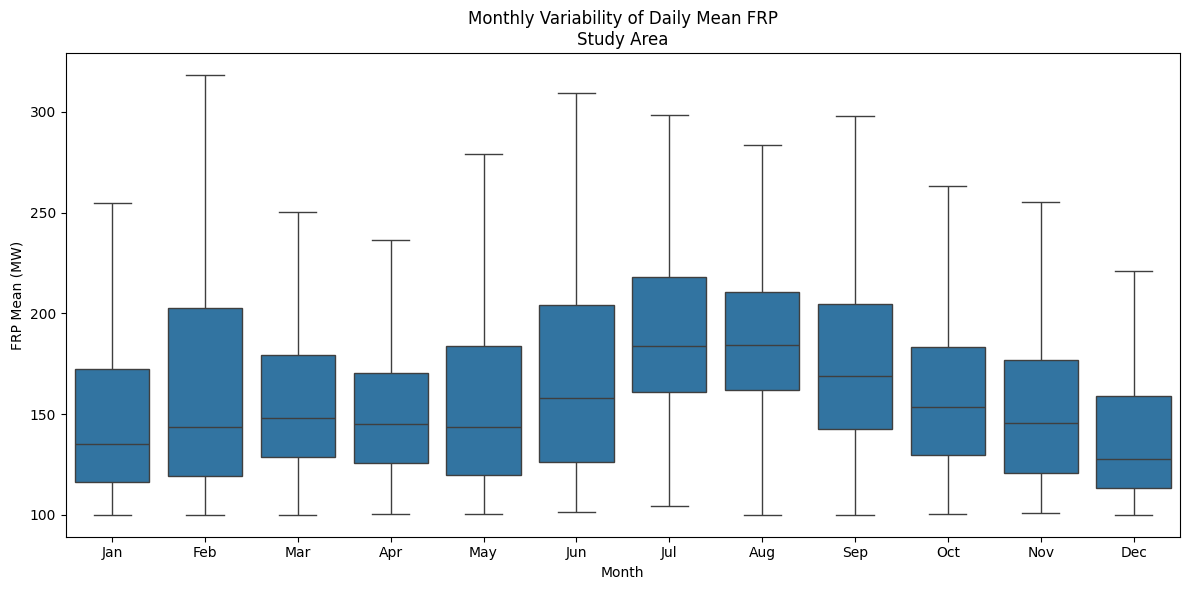

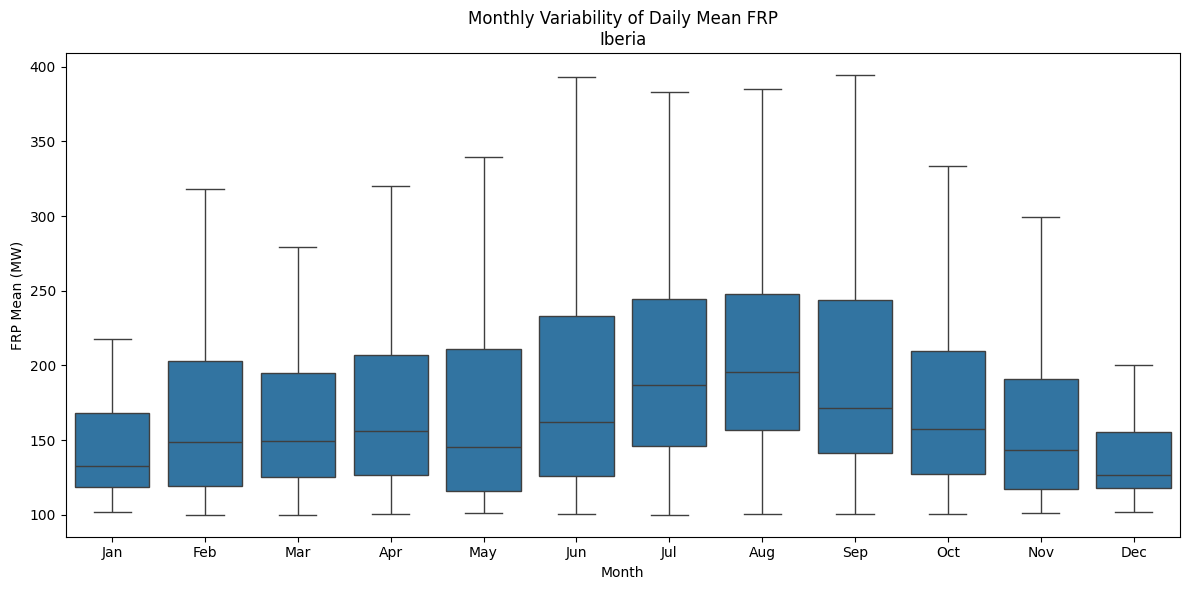

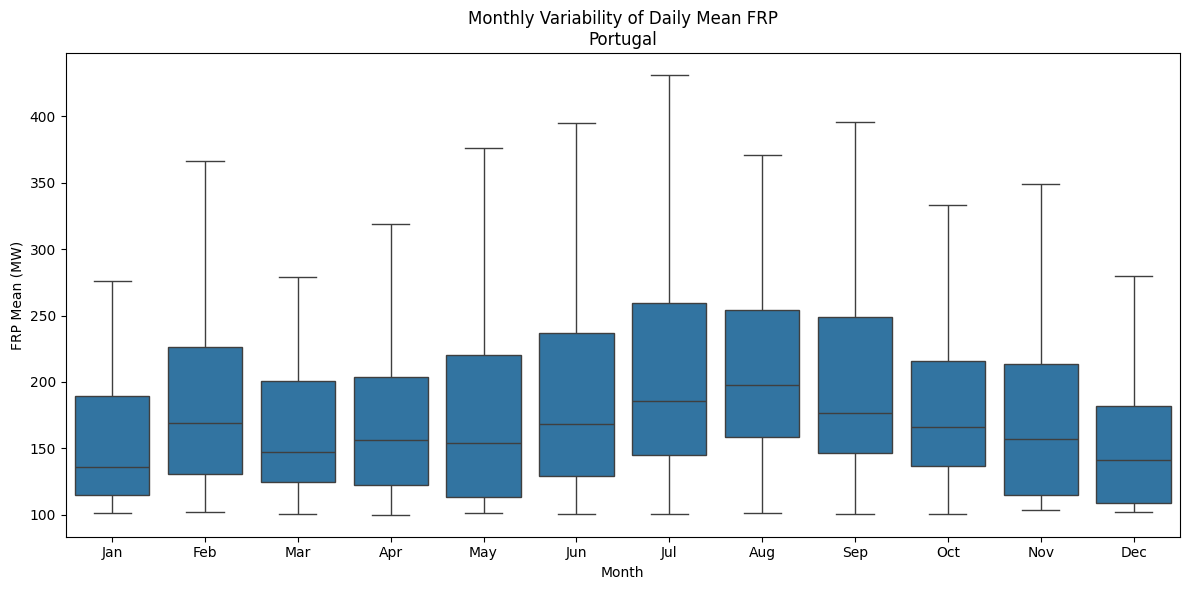

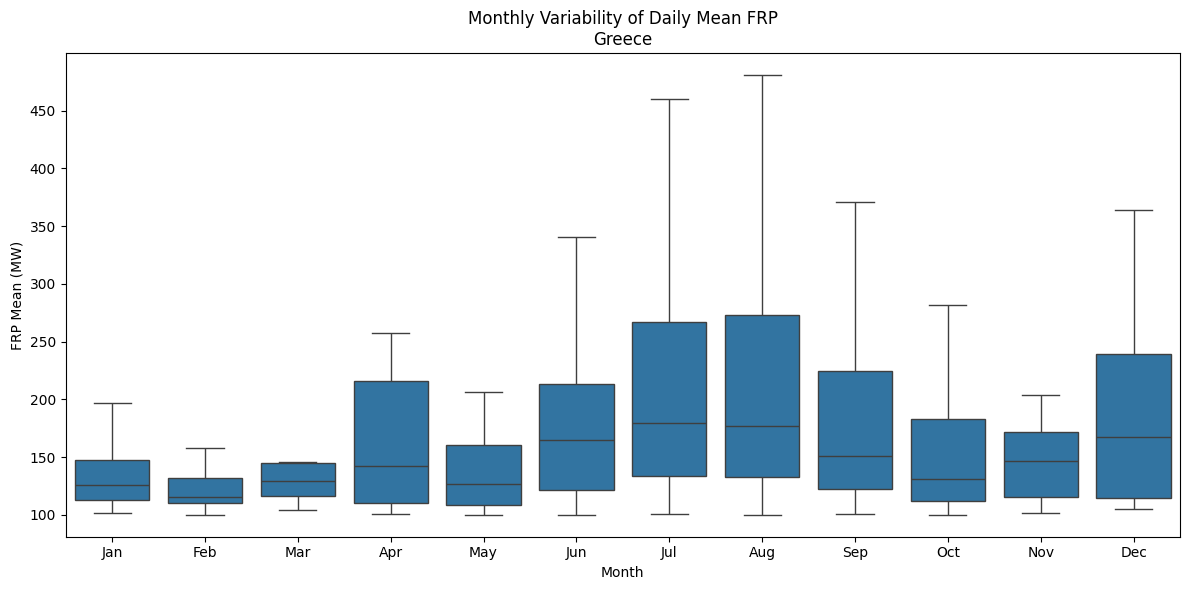

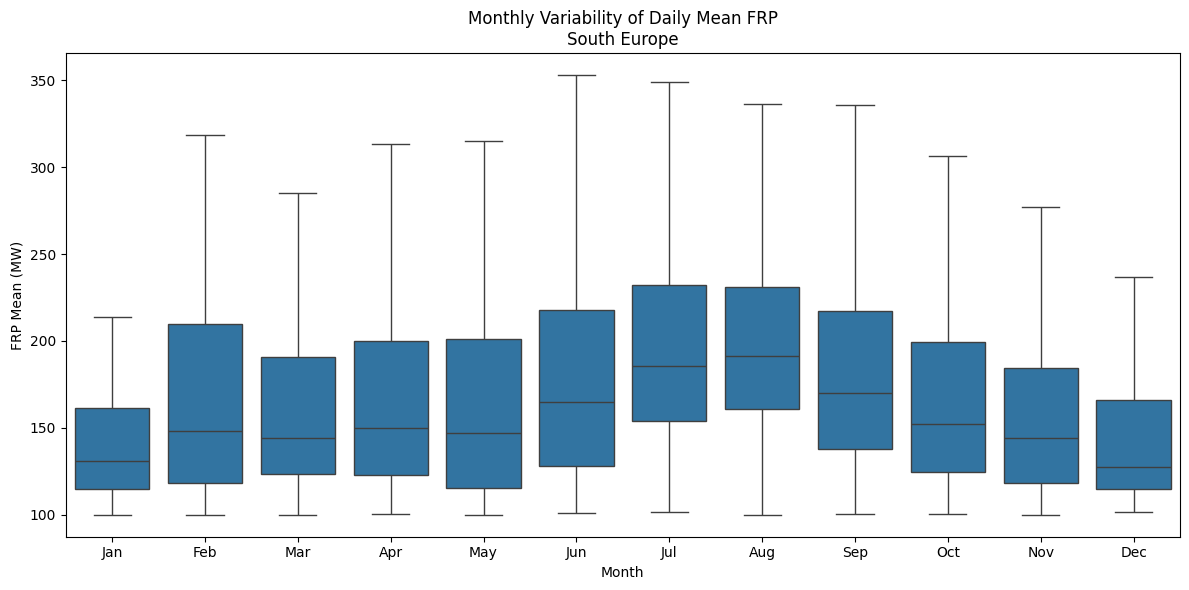

In [3]:
#Boxplot variability by month for every year

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Load the NetCDF file ===
file_path = r"E:\IPMA\FRP\FRP_2000_2024.nc"
ds = xr.open_dataset(file_path)

# === Month names for plotting ===
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# === Define regions: (lat_min, lat_max, lon_min, lon_max) ===
regions = {
    "Study Area": (34, 66, -12, 36),
    "Iberia": (35, 45, -10, 5),
    "Portugal": (36, 43, -10, -6),
    "Greece": (34, 42, 19, 29),
    "South Europe": (34, 45, -10, 29),
}

# === Loop through each region ===
for region_name, (lat_min, lat_max, lon_min, lon_max) in regions.items():
    # Subset the dataset to the region
    region_data = ds['FRP_mean'].sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

    # Average over space (grid cells)
    daily_series = region_data.mean(dim=['latitude', 'longitude'], skipna=True)

    # Convert to pandas DataFrame
    df = daily_series.to_dataframe().reset_index()

    # Extract month for grouping
    df['Month'] = df['time'].dt.month
    df['Month Name'] = df['Month'].apply(lambda m: month_names[m - 1])
    
    # Set proper month order
    df["Month Name"] = pd.Categorical(df["Month Name"], categories=month_names, ordered=True)

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Month Name", y="FRP_mean", data=df, showfliers=False, whis=1.5)
    plt.title(f"Monthly Variability of Daily Mean FRP\n{region_name}")
    plt.xlabel("Month")
    plt.ylabel("FRP Mean (MW)")
    plt.tight_layout()
    plt.show()


In [4]:
#Exceedances PROBABLY NOT THIS BUT FIRE DAYS AND NO FIRE DAYS

import xarray as xr
import numpy as np
import pandas as pd

# File and threshold
file_path = r"E:/IPMA/FRP/FRP_2000_2024.nc"
threshold = 0  # Define fire presence as FRP > 0

# Define regions: (lat_min, lat_max, lon_min, lon_max)
regions = {
    "Study Area": (34, 66, -12, 36),
    "Iberia": (35, 45, -10, 5),
    "Portugal": (36, 43, -10, -6),
    "Greece": (34, 42, 19, 29),
    "South Europe": (34, 45, -10, 29),
}

# Open dataset and select FRP_mean
ds = xr.open_dataset(file_path)
frp = ds["FRP_mean"]  # (time, latitude, longitude)

# Initialize result dictionary
results = {}

# Loop through regions
for region_name, (lat_min, lat_max, lon_min, lon_max) in regions.items():
    # Subset data
    sub_data = frp.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
    
    # Determine if there's any fire at each day (True if any cell has FRP > 0)
    daily_fire = (sub_data > threshold).any(dim=["latitude", "longitude"])
    
    # Count total fire days
    fire_day_count = daily_fire.sum().item()
    no_fire_day_count = daily_fire.size - fire_day_count
    
    results[region_name] = {
        "Fire Days": fire_day_count,
        "No Fire Days": no_fire_day_count,
        "Total Days": daily_fire.size
    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(results, orient="index")
df.index.name = "Region"
df.reset_index(inplace=True)

# Output
print(df)


         Region  Fire Days  No Fire Days  Total Days
0    Study Area       5478          3341        8819
1        Iberia       2679          6140        8819
2      Portugal       1666          7153        8819
3        Greece       1259          7560        8819
4  South Europe       4019          4800        8819


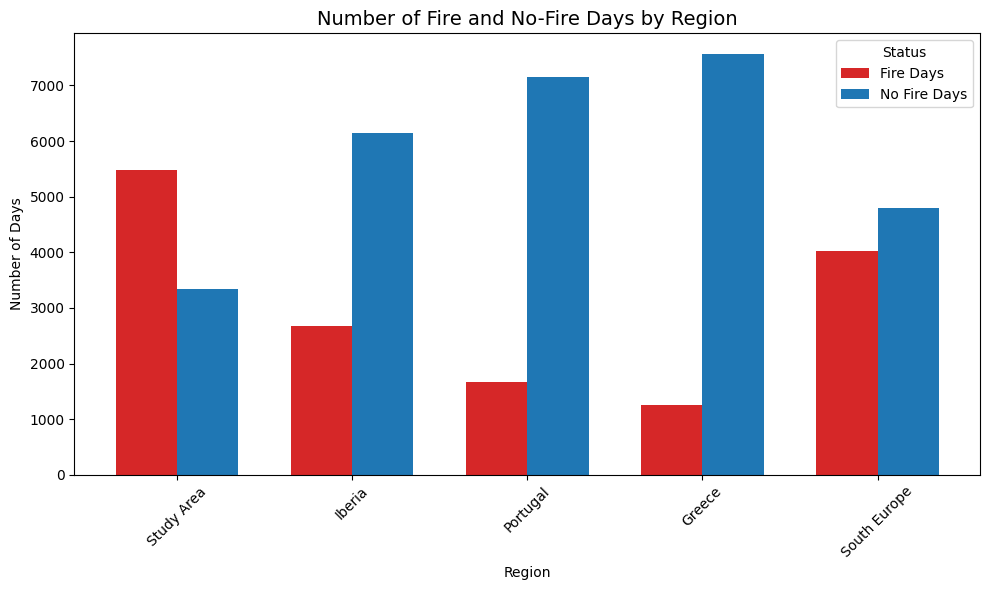

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Colors for fire status
colors = {
    "Fire Days": "tab:red",
    "No Fire Days": "tab:blue"
}

# Ensure DataFrame is loaded from previous block
# df = ...

# Melt DataFrame for plotting
df_melted = df.melt(id_vars="Region", value_vars=["Fire Days", "No Fire Days"],
                    var_name="Status", value_name="Day Count")

# Get unique regions and statuses
regions = df["Region"].unique()
statuses = ["Fire Days", "No Fire Days"]
n_statuses = len(statuses)

# Bar settings
x = np.arange(len(regions))
bar_width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, status in enumerate(statuses):
    subset = df_melted[df_melted["Status"] == status]
    values = subset["Day Count"].values
    ax.bar(x + i * bar_width, values, width=bar_width, label=status, color=colors.get(status, "gray"))

# Customization
ax.set_title("Number of Fire and No-Fire Days by Region", fontsize=14)
ax.set_ylabel("Number of Days")
ax.set_xlabel("Region")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(regions, rotation=45)
ax.legend(title="Status")

plt.tight_layout()
plt.show()


In [6]:
# Classification 4 levels  ≤50 MW (low intensity), 50 to ≤500 MW (moderate to high intensity), 500 ≤ 1000 MW (very high intensity),and >1000 MW (extreme intensity)
